<a href="https://colab.research.google.com/github/farrelrassya/IntroductionMachineLearningwithpython/blob/main/04.representing_data_and_engineering_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Representing Data and Engineering Features

So far, we've assumed that our data comes in as a two-dimensional array of floating-point numbers, where each column is a continuous feature that describes the data points. For many applications, this is not how the data is collected. A particularly common type of feature is the **categorical feature**. Also known as discrete features, these are usually not numeric. The distinction between categorical features and continuous features is analogous to the distinction between classification and regression, only on the input side rather than the output side. Examples of continuous features that we have seen are pixel brightnesses and size measurements of plant flowers. Examples of categorical features are the brand of a product, the color of a product, or the department (books, clothing, hardware) it is sold in. These are all properties that can describe a product, but they don't vary in a continuous way. A product belongs either in the clothing department or in the books department. There is no middle ground between books and clothing, and no natural order for the different categories (books is not greater or less than clothing, hardware is not between books and clothing, etc.).

Regardless of the types of features your data consists of, how you represent them can have an enormous effect on the performance of machine learning models. We saw in Chapters 2 and 3 that scaling of the data is important. In other words, if you don't rescale your data (say, to unit variance), then it makes a difference whether you represent a measurement in centimeters or inches. We also saw in Chapter 2 that it can be helpful to augment your data with additional features, like adding interactions (products) of features or more general polynomials.

The question of how to represent your data best for a particular application is known as **feature engineering**, and it is one of the main tasks of data scientists and machine learning practitioners trying to solve real-world problems. Representing your data in the right way can have a bigger influence on the performance of a supervised model than the exact parameters you choose. In supervised learning, the goal is to learn a function $f$ that maps an input feature vector $\mathbf{x} = [x_0, x_1, \ldots, x_p]$ to an output $y$:

$$f: \mathbf{x} \in \mathbb{R}^p \rightarrow y$$

The quality of this mapping depends critically on how $\mathbf{x}$ is constructed -- that is, on feature engineering.

In this chapter, we will first go over the important and very common case of categorical features, and then give some examples of helpful transformations for specific combinations of features and models.

## Setup

In [1]:
!pip install -q mglearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 9.9 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
import warnings
warnings.filterwarnings('ignore')
import os

## Categorical Variables

As an example, we will use the dataset of adult incomes in the United States, derived from the 1994 census database. The task of the **adult** dataset is to predict whether a worker has an income of over 50,000 dollars or under 50,000 dollars. The features in this dataset include the workers' ages, how they are employed (self employed, private industry employee, government employee, etc.), their education, their gender, their working hours per week, occupation, and more.

In this dataset, `age` and `hours-per-week` are continuous features, which we know how to treat. The `workclass`, `education`, `gender`, and `occupation` features are categorical, however. All of them come from a fixed list of possible values, as opposed to a range, and denote a qualitative property, as opposed to a quantity.

As a starting point, let's say we want to learn a logistic regression classifier on this data. We know from Chapter 2 that a logistic regression makes predictions using the formula:

$$\hat{y} = w_0 \cdot x_0 + w_1 \cdot x_1 + \cdots + w_p \cdot x_p + b > 0$$

or more compactly:

$$\hat{y} = \mathbf{w}^T \mathbf{x} + b > 0$$

where $w_i$ and $b$ are coefficients learned from the training set and $x_i$ are the input features. This formula makes sense when $x_i$ are numbers, but not when $x_2$ is "Masters" or "Bachelors". Clearly we need to represent our data in some different way when applying logistic regression. The next section will explain how we can overcome this problem.

First we load the data using pandas from a comma-separated values (CSV) file:

In [3]:
import os

# The file has no headers naming the columns, so we pass header=None
# and provide the column names explicitly in "names"
data = pd.read_csv(
    os.path.join(mglearn.datasets.DATA_PATH, "adult.data"),
    header=None, index_col=False,
    names=['age', 'workclass', 'fnlwgt', 'education', 'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'gender',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
           'income'])
# For illustration purposes, we only select some of the columns
data = data[['age', 'workclass', 'education', 'gender', 'hours-per-week',
             'occupation', 'income']]
# IPython.display allows nice output formatting within the Jupyter notebook
display(data.head())

,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K


The table shows the first few entries in the adult dataset, with columns for age, workclass, education, gender, hours-per-week, occupation, and income. The task is phrased as a classification task with the two classes being income <=50K and >50K.

### Checking String-Encoded Categorical Data

After reading a dataset like this, it is often good to first check if a column actually contains meaningful categorical data. When working with data that was input by humans (say, users on a website), there might not be a fixed set of categories, and differences in spelling and capitalization might require preprocessing. For example, it might be that some people specified gender as "male" and some as "man," and we might want to represent these two inputs using the same category. A good way to check the contents of a column is using the `value_counts` function of a pandas `Series` (the type of a single column in a `DataFrame`), to show us what the unique values are and how often they appear:

In [4]:
print(data.gender.value_counts())

gender
Male      21790
Female    10771
Name: count, dtype: int64


We can see that there are exactly two values for gender in this dataset, Male and Female, meaning the data is already in a good format to be represented using one-hot-encoding. In a real application, you should look at all columns and check their values. We will skip this here for brevity's sake.

### One-Hot-Encoding (Dummy Variables)

By far the most common way to represent categorical variables is using the **one-hot encoding** or **one-out-of-N encoding**, also known as **dummy variables**. The idea behind dummy variables is to replace a categorical variable with one or more new features that can have the values 0 and 1. The values 0 and 1 make sense in the formula for linear binary classification (and for all other models in scikit-learn), and we can represent any number of categories by introducing one new feature per category.

Formally, for a categorical feature with $K$ possible values, one-hot encoding creates $K$ binary features $z_1, z_2, \ldots, z_K$ where:

$$z_k = \begin{cases} 1 & \text{if the original feature equals category } k \\ 0 & \text{otherwise} \end{cases}$$

For any data point, exactly one of the $z_k$ is 1 and all others are 0 -- hence the name "one-hot."

There is a very simple way to encode the data in pandas, using the `get_dummies` function. The `get_dummies` function automatically transforms all columns that have object type (like strings) or are categorical:

In [5]:
print("Original features:\n", list(data.columns), "\n")
data_dummies = pd.get_dummies(data).astype(int)
print("Features after get_dummies:\n", list(data_dummies.columns))

Original features:
 ['age', 'workclass', 'education', 'gender', 'hours-per-week', 'occupation', 'income'] 

Features after get_dummies:
 ['age', 'hours-per-week', 'workclass_ ?', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_ 10th', 'education_ 11th', 'education_ 12th', 'education_ 1st-4th', 'education_ 5th-6th', 'education_ 7th-8th', 'education_ 9th', 'education_ Assoc-acdm', 'education_ Assoc-voc', 'education_ Bachelors', 'education_ Doctorate', 'education_ HS-grad', 'education_ Masters', 'education_ Preschool', 'education_ Prof-school', 'education_ Some-college', 'gender_ Female', 'gender_ Male', 'occupation_ ?', 'occupation_ Adm-clerical', 'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners', 'occupation_ Machine-op-i

You can see that the continuous features `age` and `hours-per-week` were not touched, while the categorical features were expanded into one new feature for each possible value. The original 7 columns have been expanded into 46 columns -- each unique category value gets its own binary column. Let's look at the actual encoded values:

In [6]:
data_dummies.head()

,age,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,...,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,income_ <=50K,income_ >50K
0,39,40,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,50,13,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,38,40,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,53,40,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,28,40,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0


Each row now contains 0s and 1s for the categorical columns: exactly one "1" per original categorical feature (one-hot). For example, the first row has `workclass_ State-gov = 1` and all other workclass columns are 0, since that person works for the state government. Mathematically, the constraint is that for each original categorical feature with $K$ categories:

$$\sum_{k=1}^{K} z_k = 1$$

We can now use the `values` attribute to convert the `data_dummies` DataFrame into a NumPy array, and then train a machine learning model on it. Be careful to separate the target variable (which is now encoded in two income columns) from the data before training a model. Including the output variable, or some derived property of the output variable, into the feature representation is a very common mistake in building supervised machine learning models.

We extract only the columns containing features -- that is, all columns from `age` to `occupation_ Transport-moving`. This range contains all the features but not the target:

In [7]:
features = data_dummies.loc[:, 'age':'occupation_ Transport-moving']
# Extract NumPy arrays
X = features.values
y = data_dummies['income_ >50K'].values
print("X.shape: {} y.shape: {}".format(X.shape, y.shape))

X.shape: (32561, 44) y.shape: (32561,)


The dataset has 32,561 samples (workers in the census) and 44 features after one-hot encoding. The target `y` is a binary array indicating whether income is >50K. Now the data is represented in a way that scikit-learn can work with, and we can proceed as usual:

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
print("Test score: {:.2f}".format(logreg.score(X_test, y_test)))

Test score: 0.81


A test score of 0.81 (81% accuracy) tells us the logistic regression achieves a reasonable baseline on this classification task. The accuracy is computed as:

$$\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} = 0.81$$

Considering this is a real-world dataset with complex interactions between employment, education, and demographics, 81% is a solid starting point -- though more sophisticated feature engineering or models could improve it further.

### Numbers Can Encode Categoricals

In the example of the adult dataset, the categorical variables were encoded as strings. On the one hand, that opens up the possibility of spelling errors, but on the other hand, it clearly marks a variable as categorical. Often, whether for ease of storage or because of the way the data is collected, categorical variables are encoded as integers. For example, imagine the census data in the adult dataset was collected using a questionnaire, and the answers for workclass were recorded as 0 (first box ticked), 1 (second box ticked), 2 (third box ticked), and so on. Now the column will contain numbers from 0 to 8, instead of strings like "Private", and it won't be immediately obvious to someone looking at the table representing the dataset whether they should treat this variable as continuous or categorical.

The `get_dummies` function in pandas treats all numbers as continuous and will not create dummy variables for them. To get around this, you can either use scikit-learn's `OneHotEncoder`, or convert numeric columns in the DataFrame to strings. To illustrate, let's create a DataFrame object with two columns, one containing strings and one containing integers:

In [9]:
# create a DataFrame with an integer feature and a categorical string feature
demo_df = pd.DataFrame({'Integer Feature': [0, 1, 2, 1],
                         'Categorical Feature': ['socks', 'fox', 'socks', 'box']})
display(demo_df)

,Integer Feature,Categorical Feature
0,0,socks
1,1,fox
2,2,socks
3,1,box


Using `get_dummies` will only encode the string feature and will not change the integer feature:

In [10]:
pd.get_dummies(demo_df).astype(int)

,Integer Feature,Categorical Feature_box,Categorical Feature_fox,Categorical Feature_socks
0,0,0,0,1
1,1,0,1,0
2,2,0,0,1
3,1,1,0,0


Notice that the "Integer Feature" column was left as-is (values 0, 1, 2, 1), while the "Categorical Feature" was expanded into three binary columns (box, fox, socks). pandas assumed the integers were continuous, which is not what we want if they represent categories.

If you want dummy variables to be created for the "Integer Feature" column as well, you can explicitly list the columns you want to encode using the `columns` parameter. Then, both features will be treated as categorical:

In [11]:
demo_df['Integer Feature'] = demo_df['Integer Feature'].astype(str)
pd.get_dummies(demo_df, columns=['Integer Feature', 'Categorical Feature']).astype(int)

,Integer Feature_0,Integer Feature_1,Integer Feature_2,Categorical Feature_box,Categorical Feature_fox,Categorical Feature_socks
0,1,0,0,0,0,1
1,0,1,0,0,1,0
2,0,0,1,0,0,1
3,0,1,0,1,0,0


Now both features have been one-hot encoded: the integer feature produced three binary columns (0, 1, 2), and the categorical feature produced three binary columns (box, fox, socks), for a total of six features. Each row has exactly one "1" per original feature. This is the correct encoding when integer values represent distinct categories rather than quantities on a continuous scale.

## Binning, Discretization, Linear Models, and Trees

The best way to represent data depends not only on the semantics of the data, but also on the kind of model you are using. Linear models and tree-based models (such as decision trees, gradient boosted trees, and random forests), two large and very commonly used families, have very different properties when it comes to how they work with different feature representations. Let's go back to the wave regression dataset that we used in Chapter 2. It has only a single input feature. Here is a comparison of a linear regression model and a decision tree regressor on this dataset.

Recall that linear regression learns a model of the form:

$$\hat{y} = w \cdot x + b$$

This can only produce a straight line. The decision tree, on the other hand, can learn a piecewise constant function by recursively splitting the feature space.

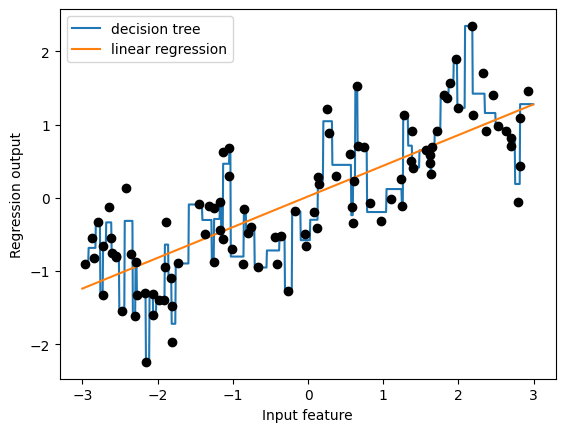

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

X, y = mglearn.datasets.make_wave(n_samples=100)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

reg = DecisionTreeRegressor(min_samples_split=3).fit(X, y)
plt.plot(line, reg.predict(line), label="decision tree")

reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), label="linear regression")

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

As you know, linear models can only model linear relationships, which are lines in the case of a single feature. The decision tree can build a much more complex model of the data. However, this is strongly dependent on the representation of the data. One way to make linear models more powerful on continuous data is to use **binning** (also known as discretization) of the feature to split it up into multiple features.

We imagine a partition of the input range for the feature (in this case, the numbers from $-3$ to $3$) into a fixed number of bins -- say, 10. A data point will then be represented by which bin it falls into. To determine this, we first have to define the bins. In this case, we'll define 10 bins equally spaced between $-3$ and $3$. We use the `np.linspace` function for this, creating 11 entries, which will create 10 bins -- they are the spaces in between two consecutive boundaries. The bin edges are computed as:

$$b_i = -3 + i \cdot \frac{6}{10}, \quad i = 0, 1, \ldots, 10$$

This gives us boundaries at $-3.0, -2.4, -1.8, \ldots, 2.4, 3.0$ with each bin having width $\Delta = 0.6$.

In [13]:
bins = np.linspace(-3, 3, 11)
print("bins: {}".format(bins))

bins: [-3.  -2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4  3. ]


Here, the first bin contains all data points with feature values $-3$ to $-2.4$, the second bin contains all points with feature values from $-2.4$ to $-1.8$, and so on. Formally, bin $k$ is defined as the interval $[b_{k-1}, b_k)$. Next, we record for each data point which bin it falls into. This can be easily computed using the `np.digitize` function:

In [14]:
which_bin = np.digitize(X, bins=bins)
print("\nData points:\n", X[:5])
print("\nBin membership for data points:\n", which_bin[:5])


Data points:
 [[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]]

Bin membership for data points:
 [[ 4]
 [10]
 [ 8]
 [ 6]
 [ 2]]


The first data point, with a value of $-0.753$, falls into bin 4 (the range from $-1.2$ to $-0.6$). The second data point, with a value of $2.704$, falls into bin 10 (the last bin, near the upper boundary). What we did here is transform the single continuous input feature in the wave dataset into a categorical feature that encodes which bin a data point is in.

To use a scikit-learn model on this data, we transform this discrete feature to a one-hot encoding using the `OneHotEncoder` from the preprocessing module. The `OneHotEncoder` does the same encoding as `pandas.get_dummies`, though it currently only works on categorical variables that are integers:

In [15]:
from sklearn.preprocessing import OneHotEncoder
# transform using the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
# encoder.fit finds the unique values that appear in which_bin
encoder.fit(which_bin)
# transform creates the one-hot encoding
X_binned = encoder.transform(which_bin)
print(X_binned[:5])
print("X_binned.shape: {}".format(X_binned.shape))

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
X_binned.shape: (100, 10)


Because we have 10 bins, the transformed dataset `X_binned` has 10 features. Each row is now a one-hot vector $\mathbf{z} \in \{0, 1\}^{10}$ where $\|\mathbf{z}\|_1 = 1$: for the first data point (bin 4), the fourth position is 1 and the rest are 0. For the second data point (bin 10), the tenth position is 1. The dataset shape is $(100, 10)$, meaning 100 data points, each represented by 10 binary features.

Now we build a new linear regression model and a new decision tree model on the one-hot-encoded data. The result is visualized together with the bin boundaries, shown as dotted black lines:

Text(0.5, 0, 'Input feature')

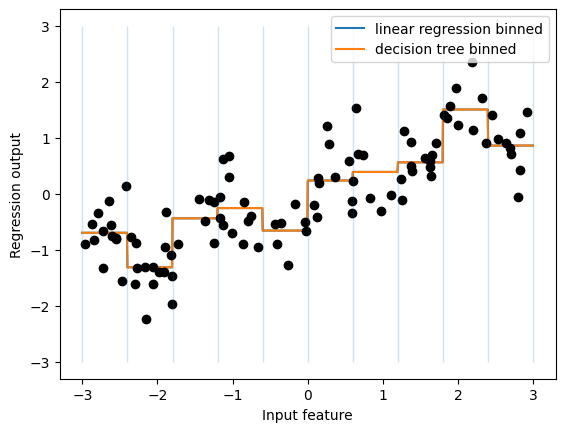

In [16]:
line_binned = encoder.transform(np.digitize(line, bins=bins))

reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='linear regression binned')

reg = DecisionTreeRegressor(min_samples_split=3).fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='decision tree binned')

plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(bins, -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")

The dashed line and solid line are exactly on top of each other, meaning the linear regression model and the decision tree make exactly the same predictions. For each bin, they predict a constant value. This is because the linear model on one-hot features effectively computes:

$$\hat{y} = w_1 z_1 + w_2 z_2 + \cdots + w_{10} z_{10} + b$$

Since exactly one $z_k = 1$ and all others are 0, the prediction for a point in bin $k$ is simply $\hat{y} = w_k + b$, which is a constant. This is equivalent to what a decision tree learns within each bin.

Comparing what the models learned before binning the features and after, we see that the linear model became much more flexible, because it now has a different value for each bin, while the decision tree model got much less flexible. Binning features generally has no beneficial effect for tree-based models, as these models can learn to split up the data anywhere. In a sense, that means decision trees can learn whatever binning is most useful for predicting on this data. Additionally, decision trees look at multiple features at once, while binning is usually done on a per-feature basis. However, the linear model benefited greatly in expressiveness from the transformation of the data.

If there are good reasons to use a linear model for a particular dataset -- say, because it is very large and high-dimensional, but some features have nonlinear relations with the output -- binning can be a great way to increase modeling power.

## Interactions and Polynomials

Another way to enrich a feature representation, particularly for linear models, is adding **interaction features** and **polynomial features** of the original data. This kind of feature engineering is often used in statistical modeling, but it's also common in many practical machine learning applications.

As a first example, look again at the previous figure. The linear model learned a constant value for each bin in the wave dataset. We know, however, that linear models can learn not only offsets, but also slopes. One way to add a slope to the linear model on the binned data is to add the original feature (the x-axis in the plot) back in. This leads to an 11-dimensional dataset with the feature vector:

$$\mathbf{x}_{\text{combined}} = [x, z_1, z_2, \ldots, z_{10}]$$

(100, 11)


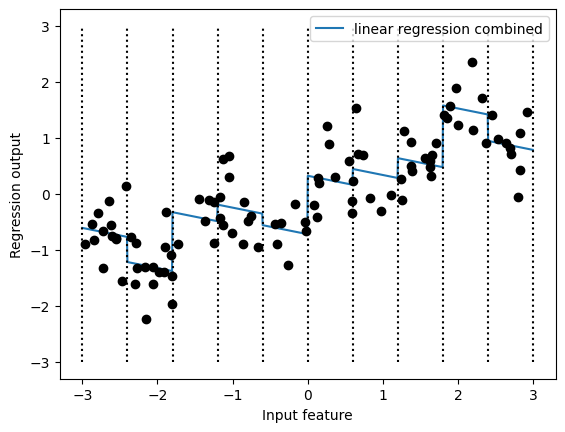

In [17]:
X_combined = np.hstack([X, X_binned])
print(X_combined.shape)

reg = LinearRegression().fit(X_combined, y)
line_combined = np.hstack([line, line_binned])
plt.plot(line, reg.predict(line_combined), label='linear regression combined')

for bin in bins:
    plt.plot([bin, bin], [-3, 3], ':', c='k')

plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.plot(X[:, 0], y, 'o', c='k')

The shape $(100, 11)$ confirms we have the original feature plus 10 bin indicators, giving 11 dimensions total. In this example, the model learned an offset for each bin, together with a slope. The prediction for a point in bin $k$ with original value $x$ becomes:

$$\hat{y} = v \cdot x + w_k + b$$

where $v$ is the shared slope. The learned slope is downward, and shared across all the bins -- there is a single $x$-axis feature, which has a single slope. Because the slope is shared across all bins, it doesn't seem to be very helpful. We would rather have a separate slope for each bin! We can achieve this by adding an **interaction** or **product** feature that indicates which bin a data point is in AND where it lies on the x-axis. This feature is a product of the bin indicator and the original feature:

$$\mathbf{x}_{\text{product}} = [z_1, z_2, \ldots, z_{10}, \; x \cdot z_1, x \cdot z_2, \ldots, x \cdot z_{10}]$$

Let's create this dataset:

In [18]:
X_product = np.hstack([X_binned, X * X_binned])
print(X_product.shape)

(100, 20)


The dataset now has 20 features: the 10 indicators for which bin a data point is in, and 10 products of the original feature with each bin indicator. You can think of the product feature $x \cdot z_k$ as a separate copy of the $x$-axis feature for each bin. It is the original feature within the bin, and zero everywhere else. The model now learns:

$$\hat{y} = \sum_{k=1}^{10} \left( w_k \cdot z_k + v_k \cdot x \cdot z_k \right) + b$$

For a point in bin $k$, this simplifies to $\hat{y} = w_k + v_k \cdot x + b$, giving each bin its own intercept $w_k$ and slope $v_k$:

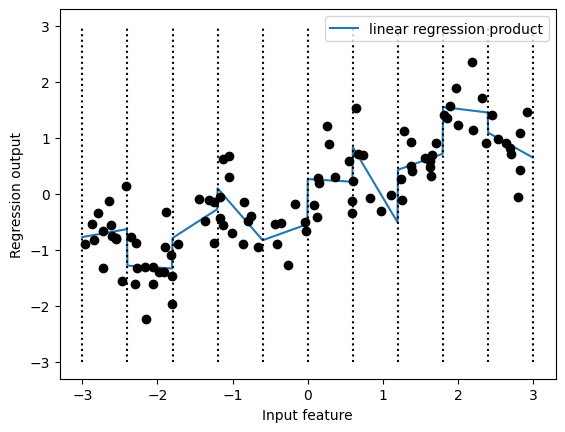

In [19]:
reg = LinearRegression().fit(X_product, y)
line_product = np.hstack([line_binned, line * line_binned])
plt.plot(line, reg.predict(line_product), label='linear regression product')

for bin in bins:
    plt.plot([bin, bin], [-3, 3], ':', c='k')

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

As you can see, now each bin has its own offset and slope in this model. This is a much more expressive representation -- the linear model can now capture different trends in different regions of the input space, something that would have been impossible with the original single-feature representation.

### Polynomial Features

Using binning is one way to expand a continuous feature. Another one is to use polynomials of the original features. For a given feature $x$, we might want to consider $x^2$, $x^3$, $x^4$, and so on. A polynomial of degree $d$ in one variable creates the feature vector:

$$\mathbf{x}_{\text{poly}} = [x, x^2, x^3, \ldots, x^d]$$

This is implemented in `PolynomialFeatures` in the preprocessing module:

In [20]:
from sklearn.preprocessing import PolynomialFeatures
# include polynomials up to x ** 10:
# the default "include_bias=True" adds a feature that's constantly 1
poly = PolynomialFeatures(degree=10, include_bias=False)
poly.fit(X)
X_poly = poly.transform(X)

Using a degree of 10 yields 10 features, corresponding to $x, x^2, x^3, \ldots, x^{10}$:

In [21]:
print("X_poly.shape: {}".format(X_poly.shape))

X_poly.shape: (100, 10)


Let's compare the entries of `X_poly` to those of `X`:

In [22]:
print("Entries of X:\n{}".format(X[:5]))
print("Entries of X_poly:\n{}".format(X_poly[:5]))

Entries of X:
[[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]]
Entries of X_poly:
[[-7.52759287e-01  5.66646544e-01 -4.26548448e-01  3.21088306e-01
  -2.41702204e-01  1.81943579e-01 -1.36959719e-01  1.03097700e-01
  -7.76077513e-02  5.84199555e-02]
 [ 2.70428584e+00  7.31316190e+00  1.97768801e+01  5.34823369e+01
   1.44631526e+02  3.91124988e+02  1.05771377e+03  2.86036036e+03
   7.73523202e+03  2.09182784e+04]
 [ 1.39196365e+00  1.93756281e+00  2.69701700e+00  3.75414962e+00
   5.22563982e+00  7.27390068e+00  1.01250053e+01  1.40936394e+01
   1.96178338e+01  2.73073115e+01]
 [ 5.91950905e-01  3.50405874e-01  2.07423074e-01  1.22784277e-01
   7.26822637e-02  4.30243318e-02  2.54682921e-02  1.50759786e-02
   8.92423917e-03  5.28271146e-03]
 [-2.06388816e+00  4.25963433e+00 -8.79140884e+00  1.81444846e+01
  -3.74481869e+01  7.72888694e+01 -1.59515582e+02  3.29222321e+02
  -6.79478050e+02  1.40236670e+03]]


You can see that the first column of `X_poly` corresponds exactly to `X`, while the other columns are the powers of the first entry. It's interesting to see how large some of the values can get. For example, the second data point has $x = 2.704$, so:

$$x^{10} = 2.704^{10} \approx 20{,}918$$

This is orders of magnitude different from the rest. This extreme variation in scale is something to be aware of when using polynomial features.

Let's also look at the feature names:

In [23]:
print("Polynomial feature names:\n{}".format(poly.get_feature_names_out()))

Polynomial feature names:
['x0' 'x0^2' 'x0^3' 'x0^4' 'x0^5' 'x0^6' 'x0^7' 'x0^8' 'x0^9' 'x0^10']


The feature names confirm the progression: $x_0$, $x_0^2$, $x_0^3$, all the way through $x_0^{10}$. Each feature is simply the original feature raised to a higher power.

Using polynomial features together with a linear regression model yields the classical model of **polynomial regression**:

$$\hat{y} = w_1 x + w_2 x^2 + w_3 x^3 + \cdots + w_d x^d + b$$

This is still a *linear* model -- linear in the parameters $w_i$ -- even though the relationship with $x$ is nonlinear:

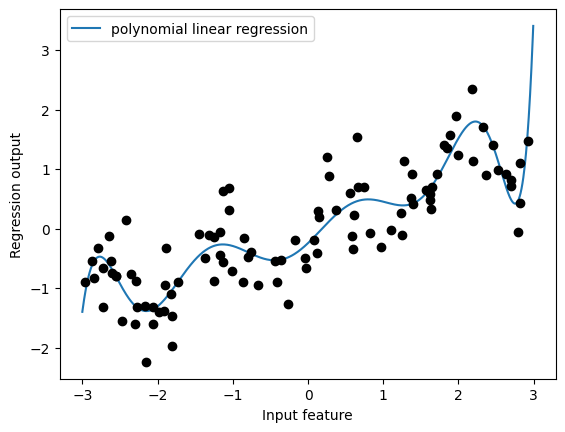

In [24]:
reg = LinearRegression().fit(X_poly, y)
line_poly = poly.transform(line)
plt.plot(line, reg.predict(line_poly), label='polynomial linear regression')
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

As you can see, polynomial features yield a very smooth fit on this one-dimensional data. However, polynomials of high degree tend to behave in extreme ways on the boundaries or in regions with little data.

As a comparison, here is a kernel SVM model learned on the original data, without any transformation:

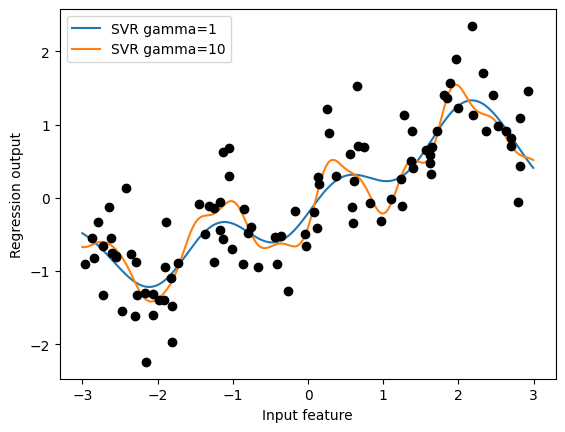

In [25]:
from sklearn.svm import SVR

for gamma in [1, 10]:
    svr = SVR(gamma=gamma).fit(X, y)
    plt.plot(line, svr.predict(line), label='SVR gamma={}'.format(gamma))

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

Using a more complex model, a kernel SVM, we are able to learn a similarly complex prediction to the polynomial regression without an explicit transformation of the features. The SVM with the RBF (radial basis function) kernel computes similarity using:

$$K(x, x') = \exp\left(-\gamma \|x - x'\|^2\right)$$

With $\gamma = 1$, the SVM produces a smooth fit, while $\gamma = 10$ creates a more wiggly curve that closely tracks each data point. Higher $\gamma$ makes the influence of each training point more local, leading to a more complex decision boundary. This illustrates a fundamental trade-off: you can either transform your features to be more expressive (polynomial features with a linear model) or use a more complex model that can handle the original features directly (kernel SVM).

### Interactions and Polynomials on the Boston Housing Dataset

As a more realistic application of interactions and polynomials, let's look again at the Boston Housing dataset. We already used polynomial features on this dataset in Chapter 2. Now let's have a look at how these features were constructed, and at how much the polynomial features help. First we load the data, and rescale it to be between 0 and 1 using `MinMaxScaler`:

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import Bunch
import os

# Boston Housing dataset (load_boston removed in sklearn 1.2+)
def load_boston():
    """Load the Boston Housing dataset from bundled CSV or download if needed."""
    import pandas as pd
    # Try multiple possible locations for the CSV
    possible_paths = [
        "boston_house_prices.csv",
        "sklearn/datasets/data/boston_house_prices.csv",
        os.path.join(os.path.expanduser("~"), "boston_house_prices.csv"),
    ]
    for path in possible_paths:
        if os.path.exists(path):
            df = pd.read_csv(path, skiprows=1)
            return Bunch(data=df.iloc[:, :-1].values,
                         target=df.iloc[:, -1].values,
                         feature_names=df.columns[:-1].tolist())
    # If not found locally, download from PyPI (sklearn 1.1.3 wheel)
    import urllib.request, json as _json, zipfile, tempfile
    print("Downloading Boston Housing data...")
    url = "https://pypi.org/pypi/scikit-learn/1.1.3/json"
    with urllib.request.urlopen(url) as resp:
        pkg = _json.loads(resp.read())
    whl_url = [f['url'] for f in pkg['urls']
                if f['filename'].endswith('cp311-cp311-win_amd64.whl')][0]
    with tempfile.NamedTemporaryFile(suffix='.whl') as tmp:
        urllib.request.urlretrieve(whl_url, tmp.name)
        with zipfile.ZipFile(tmp.name) as z:
            with z.open('sklearn/datasets/data/boston_house_prices.csv') as csv_f:
                df = pd.read_csv(csv_f, skiprows=1)
    return Bunch(data=df.iloc[:, :-1].values,
                 target=df.iloc[:, -1].values,
                 feature_names=df.columns[:-1].tolist())

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, random_state=0)

# rescale data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Now, we extract polynomial features and interactions up to a degree of 2:

In [27]:
poly = PolynomialFeatures(degree=2).fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_poly.shape: {}".format(X_train_poly.shape))

X_train.shape: (379, 13)
X_train_poly.shape: (379, 105)


The data originally had 13 features, which were expanded into 105 interaction features. For $p$ original features with degree $d = 2$ (including the bias term), the number of output features is:

$$\binom{p + d}{d} = \binom{13 + 2}{2} = \binom{15}{2} = 105$$

These new features represent all possible interactions between two different original features (e.g., $x_i \cdot x_j$), the square of each original feature (e.g., $x_i^2$), the original features themselves, and a constant bias term "1". The exact correspondence between input and output features can be found using the `get_feature_names_out` method:

In [28]:
print("Polynomial feature names:\n{}".format(poly.get_feature_names_out()))

Polynomial feature names:
['1' 'x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x8' 'x9' 'x10' 'x11' 'x12'
 'x0^2' 'x0 x1' 'x0 x2' 'x0 x3' 'x0 x4' 'x0 x5' 'x0 x6' 'x0 x7' 'x0 x8'
 'x0 x9' 'x0 x10' 'x0 x11' 'x0 x12' 'x1^2' 'x1 x2' 'x1 x3' 'x1 x4' 'x1 x5'
 'x1 x6' 'x1 x7' 'x1 x8' 'x1 x9' 'x1 x10' 'x1 x11' 'x1 x12' 'x2^2' 'x2 x3'
 'x2 x4' 'x2 x5' 'x2 x6' 'x2 x7' 'x2 x8' 'x2 x9' 'x2 x10' 'x2 x11'
 'x2 x12' 'x3^2' 'x3 x4' 'x3 x5' 'x3 x6' 'x3 x7' 'x3 x8' 'x3 x9' 'x3 x10'
 'x3 x11' 'x3 x12' 'x4^2' 'x4 x5' 'x4 x6' 'x4 x7' 'x4 x8' 'x4 x9' 'x4 x10'
 'x4 x11' 'x4 x12' 'x5^2' 'x5 x6' 'x5 x7' 'x5 x8' 'x5 x9' 'x5 x10'
 'x5 x11' 'x5 x12' 'x6^2' 'x6 x7' 'x6 x8' 'x6 x9' 'x6 x10' 'x6 x11'
 'x6 x12' 'x7^2' 'x7 x8' 'x7 x9' 'x7 x10' 'x7 x11' 'x7 x12' 'x8^2' 'x8 x9'
 'x8 x10' 'x8 x11' 'x8 x12' 'x9^2' 'x9 x10' 'x9 x11' 'x9 x12' 'x10^2'
 'x10 x11' 'x10 x12' 'x11^2' 'x11 x12' 'x12^2']


The first new feature is a constant feature, called "1" here. The next 13 features are the original features (called "x0" to "x12"). Then follows the first feature squared ("x0^2") and combinations of the first and the other features. This combinatorial expansion captures relationships that a linear model couldn't see in the original feature space.

Let's compare the performance using Ridge on the data with and without interactions:

In [29]:
from sklearn.linear_model import Ridge
ridge = Ridge().fit(X_train_scaled, y_train)
print("Score without interactions: {:.3f}".format(
    ridge.score(X_test_scaled, y_test)))
ridge = Ridge().fit(X_train_poly, y_train)
print("Score with interactions: {:.3f}".format(
    ridge.score(X_test_poly, y_test)))

Score without interactions: 0.621
Score with interactions: 0.753


Clearly, the interactions and polynomial features gave us a substantial boost in performance when using Ridge -- from 0.621 to 0.753, a relative improvement of over 20%. Ridge regression minimizes the objective:

$$\min_{\mathbf{w}} \sum_{i=1}^{n} \left( y_i - \mathbf{w}^T \mathbf{x}_i - b \right)^2 + \alpha \|\mathbf{w}\|_2^2$$

where the L2 penalty $\alpha \|\mathbf{w}\|_2^2$ prevents overfitting despite the expanded feature space. The improvement makes sense: the housing price likely depends on interactions between features (e.g., a large house in a good neighborhood is worth more than the sum of "large" and "good neighborhood" alone). The Ridge model with polynomial features can capture these interaction effects.

When using a more complex model like a random forest, the story is a bit different, though:

In [30]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=0).fit(X_train_scaled, y_train)
print("Score without interactions: {:.3f}".format(
    rf.score(X_test_scaled, y_test)))
rf = RandomForestRegressor(n_estimators=100, random_state=0).fit(X_train_poly, y_train)
print("Score with interactions: {:.3f}".format(rf.score(X_test_poly, y_test)))

Score without interactions: 0.795
Score with interactions: 0.780


You can see that even without additional features, the random forest beats the performance of Ridge ($0.795$ vs. $0.621$). Adding interactions and polynomials actually *decreases* performance slightly for the random forest (from $0.795$ to $0.780$). This is a crucial insight: **tree-based models can discover interactions on their own** by making hierarchical splits, so explicitly adding interaction features just increases dimensionality without adding useful information. The extra features may even hurt by making the model more prone to overfitting on spurious correlations in the expanded feature space.

## Univariate Nonlinear Transformations

We just saw that adding squared or cubed features can help linear models for regression. There are other transformations that often prove useful for transforming certain features: in particular, applying mathematical functions like $\log$, $\exp$, or $\sin$. While tree-based models only care about the ordering of the features, linear models and neural networks are very tied to the scale and distribution of each feature, and if there is a nonlinear relation between the feature and the target, that becomes hard to model -- particularly in regression. The functions $\log$ and $\exp$ can help by adjusting the relative scales in the data so that they can be captured better by a linear model or neural network. The $\sin$ and $\cos$ functions can come in handy when dealing with data that encodes periodic patterns.

Most models work best when each feature (and in regression also the target) is loosely Gaussian distributed -- that is, a histogram of each feature should have something resembling the familiar "bell curve" shape described by:

$$p(x) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right)$$

Using transformations like $\log$ and $\exp$ is a hacky but simple and efficient way to achieve this. A particularly common case when such a transformation can be helpful is when dealing with integer count data. By count data, we mean features like "how often did user A log in?" Counts are never negative, and often follow particular statistical patterns. We are using a synthetic dataset of counts here that has properties similar to those you can find in the wild. The data is generated from a Poisson distribution:

$$X \sim \text{Poisson}\left(10 \cdot \exp(X_{\text{org}})\right)$$

where $X_{\text{org}}$ comes from a standard normal distribution, and the target is the linear combination $y = \mathbf{w}^T X_{\text{org}}$.

In [31]:
rnd = np.random.RandomState(0)
X_org = rnd.normal(size=(1000, 3))
w = rnd.normal(size=3)

X = rnd.poisson(10 * np.exp(X_org))
y = np.dot(X_org, w)

If we count the appearance of each value, the distribution of values becomes clearer:

In [32]:
print("Number of feature appearances:\n{}".format(np.bincount(X[:, 0])))

Number of feature appearances:
[28 38 68 48 61 59 45 56 37 40 35 34 36 26 23 26 27 21 23 23 18 21 10  9
 17  9  7 14 12  7  3  8  4  5  5  3  4  2  4  1  1  3  2  5  3  8  2  5
  2  1  2  3  3  2  2  3  3  0  1  2  1  0  0  3  1  0  0  0  1  3  0  1
  0  2  0  1  1  0  0  0  0  1  0  0  2  2  0  1  1  0  0  0  0  1  1  0
  0  0  0  0  0  0  1  0  0  0  0  0  1  1  0  0  1  0  0  0  0  0  0  0
  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]


The value 2 seems to be the most common, with 68 appearances (bincount always starts at 0), and the counts for higher values fall quickly. However, there are some very high values, like 134 appearing twice. This heavily right-skewed distribution is characteristic of count data generated by a Poisson process, where the probability mass function is:

$$P(X = k) = \frac{\lambda^k e^{-\lambda}}{k!}$$

with the rate parameter $\lambda = 10 \cdot \exp(X_{\text{org}})$ varying across data points. We visualize the counts:

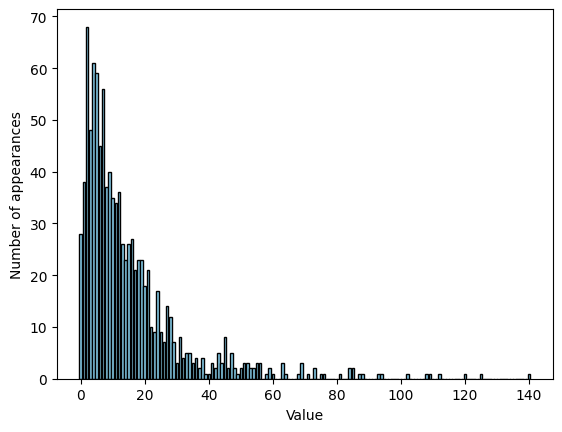

In [33]:
# Assuming X contains non-negative integers
bins = np.bincount(X[:, 0])

# BEST PRACTICE: Use a visible color and add an edgecolor for visual clarity
plt.bar(range(len(bins)), bins, color='skyblue', edgecolor='black')

plt.ylabel("Number of appearances")
plt.xlabel("Value")
plt.show()

Features `X[:, 1]` and `X[:, 2]` have similar properties. This kind of distribution of values (many small ones and a few very large ones) is very common in practice. However, it is something most linear models can't handle very well. The extreme outliers will dominate the learned coefficients, and the model will struggle to capture the pattern in the bulk of the data. Let's try to fit a Ridge regression to this model:

In [34]:
from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
score = Ridge().fit(X_train, y_train).score(X_test, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.622


As you can see from the relatively low $R^2$ score of 0.622, Ridge was not able to really capture the relationship between $X$ and $y$. The coefficient of determination $R^2$ is defined as:

$$R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}$$

where $\bar{y}$ is the mean of $y$. An $R^2$ of 1.0 indicates perfect prediction, while $R^2 = 0$ means the model predicts no better than simply predicting the mean. Here, $R^2 = 0.622$ means the model explains about 62% of the variance.

The problem is that the skewed distribution violates the assumptions of linear regression -- the model is trying to fit a line through data that spans orders of magnitude. Applying a logarithmic transformation can help, though. Because the value 0 appears in the data (and the logarithm is not defined at 0), we can't actually just apply $\log$, but we have to compute $\log(X + 1)$:

$$X_{\text{log}} = \log(X + 1)$$

This is sometimes called the **log1p** transformation.

In [35]:
X_train_log = np.log(X_train + 1)
X_test_log = np.log(X_test + 1)

After the transformation, the distribution of the data is less asymmetrical and doesn't have very large outliers anymore:

Text(0.5, 0, 'Value')

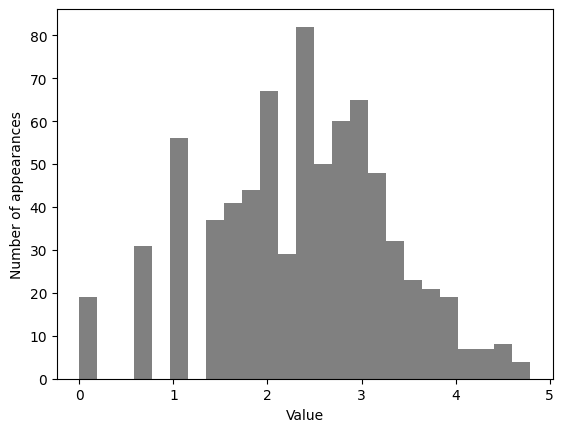

In [36]:
plt.hist(X_train_log[:, 0], bins=25, color='gray')
plt.ylabel("Number of appearances")
plt.xlabel("Value")

The log-transformed distribution looks much closer to a Gaussian bell curve, which is exactly what linear models expect. The extreme values (50, 100, 134) that previously dominated the distribution have been compressed: for example, $\log(134 + 1) \approx 4.91$, while $\log(2 + 1) \approx 1.10$. The ratio shrinks from $67\times$ to just $4.5\times$. Building a Ridge model on the new data provides a much better fit:

In [37]:
score = Ridge().fit(X_train_log, y_train).score(X_test_log, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.875


The $R^2$ score jumped from 0.622 to 0.875 -- a dramatic improvement from a single, simple transformation. This is because the true underlying relationship was:

$$X = \text{Poisson}\left(10 \cdot \exp(X_{\text{org}})\right)$$

so applying $\log(X + 1)$ approximately recovers:

$$\log(X + 1) \approx \log\left(10 \cdot \exp(X_{\text{org}})\right) = \log(10) + X_{\text{org}}$$

This means $\log(X + 1)$ is approximately a linear function of $X_{\text{org}}$, and since $y = \mathbf{w}^T X_{\text{org}}$, the log-transformed features now have a nearly linear relationship with the target -- exactly what Ridge regression can model.

Finding the transformation that works best for each combination of dataset and model is somewhat of an art. In this example, all the features had the same properties. This is rarely the case in practice, and usually only a subset of the features should be transformed, or sometimes each feature needs to be transformed in a different way.

As we mentioned earlier, these kinds of transformations are irrelevant for tree-based models but might be essential for linear models. Sometimes it is also a good idea to transform the target variable $y$ in regression. Trying to predict counts (say, number of orders) is a fairly common task, and using the $\log(y + 1)$ transformation often helps.

As you saw in the previous examples, binning, polynomials, and interactions can have a huge influence on how models perform on a given dataset. This is particularly true for less complex models like linear models and naive Bayes models. Tree-based models, on the other hand, are often able to discover important interactions themselves, and don't require transforming the data explicitly most of the time. Other models, like SVMs, nearest neighbors, and neural networks, might sometimes benefit from using binning, interactions, or polynomials, but the implications there are usually much less clear than in the case of linear models.

## Automatic Feature Selection

With so many ways to create new features, you might get tempted to increase the dimensionality of the data way beyond the number of original features. However, adding more features makes all models more complex, and so increases the chance of overfitting. When adding new features, or with high-dimensional datasets in general, it can be a good idea to reduce the number of features to only the most useful ones, and discard the rest. This can lead to simpler models that generalize better. But how can you know how good each feature is? There are three basic strategies: **univariate statistics**, **model-based selection**, and **iterative selection**. We will discuss all three of them in detail. All of these methods are supervised methods, meaning they need the target for fitting the model. This means we need to split the data into training and test sets, and fit the feature selection only on the training part of the data.

### Univariate Statistics

In univariate statistics, we compute whether there is a statistically significant relationship between each feature and the target. Then the features that are related with the highest confidence are selected. In the case of classification, this is also known as **analysis of variance (ANOVA)**. The F-statistic for each feature $x_j$ measures the ratio of between-class variance to within-class variance:

$$F_j = \frac{\text{Var}_{\text{between}}(x_j)}{\text{Var}_{\text{within}}(x_j)}$$

A high $F$-value indicates that the feature separates the classes well, and the associated $p$-value tells us how likely this separation would be by chance. Features with $p$-values below a threshold are kept.

A key property of these tests is that they are **univariate**, meaning that they only consider each feature individually. Consequently, a feature will be discarded if it is only informative when combined with another feature. Univariate tests are often very fast to compute, and don't require building a model. On the other hand, they are completely independent of the model that you might want to apply after the feature selection.

To use univariate feature selection in scikit-learn, you need to choose a test, usually either `f_classif` (the default) for classification or `f_regression` for regression, and a method to discard features based on the $p$-values determined in the test. The methods differ in how they compute this threshold, with the simplest ones being `SelectKBest`, which selects a fixed number $k$ of features, and `SelectPercentile`, which selects a fixed percentage of features. Let's apply the feature selection for classification on the cancer dataset. To make the task a bit harder, we'll add some noninformative noise features to the data. We expect the feature selection to be able to identify the features that are noninformative and remove them:

In [38]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

# get deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))

# add noise features to the data
# the first 30 features are from the dataset, the next 50 are noise
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(
    X_w_noise, cancer.target, random_state=0, test_size=.5)

# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)

# transform training set
X_train_selected = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


As you can see, the number of features was reduced from 80 to 40 (50 percent of the original number of features). We started with 30 real features from the breast cancer dataset and 50 noise features for a total of 80. After selection, we kept 40 -- ideally the 30 real ones plus 10 "lucky" noise features that happened to correlate with the target by chance.

We can find out which features have been selected using the `get_support` method, which returns a Boolean mask of the selected features -- visualized here where black is True (selected) and white is False (discarded):

[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


Text(0.5, 0, 'Sample index')

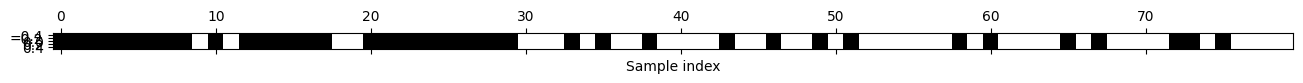

In [39]:
mask = select.get_support()
print(mask)
# visualize the mask -- black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")

As you can see from the visualization of the mask, most of the selected features are the original features (the first 30 positions, mostly black), and most of the noise features (positions 30-79) were removed. However, the recovery of the original features is not perfect -- a few real features were missed, and a handful of noise features slipped through. This is expected: univariate tests can miss features that are only informative in combination with other features, and random noise occasionally correlates with the target by chance.

Let's compare the performance of logistic regression on all features against the performance using only the selected features:

In [40]:
from sklearn.linear_model import LogisticRegression

# transform test data
X_test_selected = select.transform(X_test)

lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)
print("Score with all features: {:.3f}".format(lr.score(X_test, y_test)))
lr.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(
    lr.score(X_test_selected, y_test)))

Score with all features: 0.930
Score with only selected features: 0.940


In this case, removing the noise features improved performance, from 0.930 to 0.940. Even though some original features were lost, eliminating the 40 noise features reduced the model's tendency to overfit on spurious patterns. This was a very simple synthetic example, and outcomes on real data are usually mixed. Univariate feature selection can still be very helpful, though, if there is such a large number of features that building a model on them is infeasible, or if you suspect that many features are completely uninformative.

### Model-Based Feature Selection

Model-based feature selection uses a supervised machine learning model to judge the importance of each feature, and keeps only the most important ones. The supervised model that is used for feature selection doesn't need to be the same model that is used for the final supervised modeling. The feature selection model needs to provide some measure of importance for each feature, so that they can be ranked by this measure. Decision trees and decision tree-based models provide a `feature_importances_` attribute, which directly encodes the importance of each feature. Linear models have coefficients, which can also be used to capture feature importances by considering the absolute values $|w_j|$. As we saw in Chapter 2, linear models with L1 penalty learn sparse coefficients by minimizing:

$$\min_{\mathbf{w}} \sum_{i=1}^{n} L(y_i, \hat{y}_i) + \alpha \sum_{j=1}^{p} |w_j|$$

The L1 term $\alpha \|\mathbf{w}\|_1$ drives many coefficients to exactly zero, which can be viewed as a form of feature selection for the model itself, but can also be used as a preprocessing step to select features for another model. In contrast to univariate selection, model-based selection considers all features at once, and so can capture interactions (if the model can capture them). To use model-based feature selection, we need to use the `SelectFromModel` transformer:

In [41]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")

The `SelectFromModel` class selects all features that have an importance measure of the feature (as provided by the supervised model) greater than the provided threshold. To get a comparable result to what we got with univariate feature selection, we used the median as a threshold, so that half of the features will be selected. We use a random forest classifier with 100 trees to compute the feature importances. This is a quite complex model and much more powerful than using univariate tests. Now let's actually fit the model:

In [42]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


Again, we can have a look at the features that were selected:

Text(0.5, 0, 'Sample index')

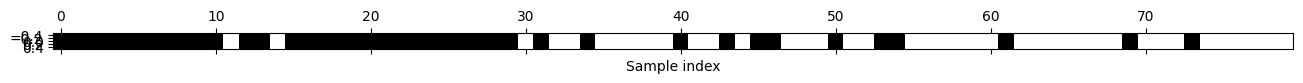

In [43]:
mask = select.get_support()
# visualize the mask -- black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")

This time, all but two of the original features were selected. Because we specified to select 40 features, some of the noise features are also selected -- but the model-based approach correctly identified almost all 30 real features, which is better than the univariate approach that missed several. Let's take a look at the performance:

In [44]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression(solver='liblinear').fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.951


With the better feature selection, we achieved 0.951 accuracy -- an improvement over both the univariate approach (0.940) and using all features (0.930). The random forest-based selection was able to identify the most informative features by considering feature interactions, something the univariate tests cannot do.

### Iterative Feature Selection

In univariate testing we used no model, while in model-based selection we used a single model to select features. In iterative feature selection, a series of models are built, with varying numbers of features. There are two basic methods: starting with no features and adding features one by one (**forward selection**) until some stopping criterion is reached, or starting with all features and removing features one by one (**backward elimination**) until some stopping criterion is reached. Because a series of models are built, these methods are much more computationally expensive than the methods we discussed previously. One particular method of this kind is **recursive feature elimination (RFE)**, which starts with all $p$ features, builds a model, and discards the least important feature according to the model. Then a new model is built using all but the discarded feature, and so on until only a prespecified number of features $k$ are left. This requires training $p - k$ models in total. For this to work, the model used for selection needs to provide some way to determine feature importance, as was the case for the model-based selection. Here, we use the same random forest model that we used earlier:

Text(0.5, 0, 'Sample index')

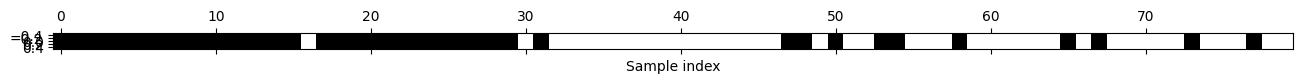

In [45]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=40)

select.fit(X_train, y_train)
# visualize the selected features:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")

The feature selection got better compared to the univariate and model-based selection, but one feature was still missed. Running this code also takes significantly longer than that for the model-based selection, because a random forest model is trained 40 times, once for each feature that is dropped. Let's test the accuracy of the logistic regression model when using RFE for feature selection:

In [46]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = LogisticRegression(solver='liblinear').fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.951


We can also use the model used inside the RFE to make predictions. This uses only the feature set that was selected:

In [47]:
print("Test score: {:.3f}".format(select.score(X_test, y_test)))

Test score: 0.951


Here, the performance of the random forest used inside the RFE is the same as that achieved by training a logistic regression model on top of the selected features. Both achieve 0.951 accuracy. In other words, once we've selected the right features, the linear model performs as well as the random forest. This is a powerful insight: a simple, interpretable model with the right features can match a complex model with all features.

If you are unsure when selecting what to use as input to your machine learning algorithms, automatic feature selection can be quite helpful. It is also great for reducing the amount of features needed -- for example, to speed up prediction or to allow for more interpretable models. In most real-world cases, applying feature selection is unlikely to provide large gains in performance. However, it is still a valuable tool in the toolbox of the feature engineer.

## Utilizing Expert Knowledge

Feature engineering is often an important place to use expert knowledge for a particular application. While the purpose of machine learning in many cases is to avoid having to create a set of expert-designed rules, that doesn't mean that prior knowledge of the application or domain should be discarded. Often, domain experts can help in identifying useful features that are much more informative than the initial representation of the data.

We'll now look at one particular case of using expert knowledge -- though in this case it might be more rightfully called "common sense." The task is predicting bicycle rentals in front of Andreas's house.

In New York, Citi Bike operates a network of bicycle rental stations with a subscription system. The stations are all over the city and provide a convenient way to get around. Bike rental data is made public in an anonymized form and has been analyzed in various ways. The task we want to solve is to predict for a given time and day how many people will rent a bike in front of Andreas's house -- so he knows if any bikes will be left for him.

We first load the data for August 2015 for this particular station as a pandas DataFrame. We resample the data into three-hour intervals to obtain the main trends for each day:

In [48]:
citibike = mglearn.datasets.load_citibike()

In [49]:
print("Citi Bike data:\n{}".format(citibike.head()))

Citi Bike data:
starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3h, Name: one, dtype: int64


The data shows rental counts aggregated in three-hour windows. At midnight on August 1st, there were 3 rentals; at 3 AM, zero; by 9 AM, 41 rentals -- clearly showing the day/night cycle. The following example shows a visualization of the rental frequencies for the whole month:

Text(0, 0.5, 'Rentals')

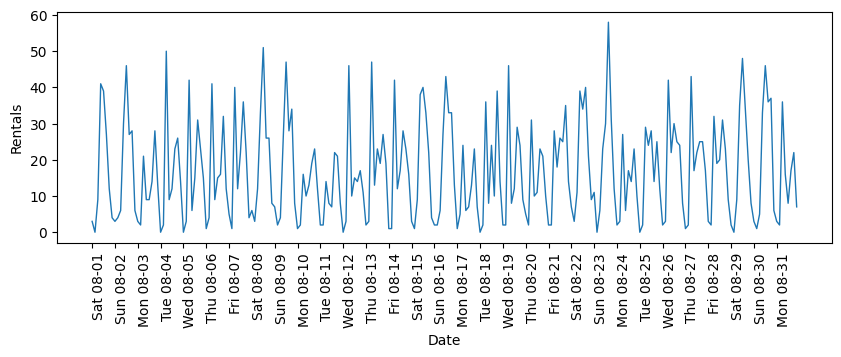

In [50]:
plt.figure(figsize=(10, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(),
                        freq='D')
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(citibike, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals")

Looking at the data, we can clearly distinguish day and night for each 24-hour interval. The patterns for weekdays and weekends also seem to be quite different. When evaluating a prediction task on a time series like this, we usually want to learn from the past and predict for the future. This means when doing a split into a training and a test set, we want to use all the data up to a certain date as the training set and all the data past that date as the test set. We will use the first 184 data points, corresponding to the first 23 days, as our training set, and the remaining 64 data points, corresponding to the remaining 8 days, as our test set.

The only feature that we are using in our prediction task is the date and time when a particular number of rentals occurred. A (surprisingly) common way that dates are stored on computers is using **POSIX time**, which is the number of seconds since January 1, 1970, 00:00:00 UTC (aka the beginning of Unix time). So each timestamp $t$ is a single integer:

$$t = \text{seconds since 1970-01-01 00:00:00}$$

As a first try, we can use this single integer feature as our data representation:

In [51]:
# extract the target values (number of rentals)
y = citibike.values
# convert the time to POSIX time using "%s"
X = citibike.index.strftime("%s").astype("int").values.reshape(-1, 1)

We first define a function to split the data into training and test sets, build the model, and visualize the result:

In [52]:
# use the first 184 data points for training, and the rest for testing
n_train = 184

# function to evaluate and plot a regressor on a given feature set
def eval_on_features(features, target, regressor):
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    # also split the target array
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(10, 3))
    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90,
               ha="left")
    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test")
    plt.plot(range(n_train), y_pred_train, '--', label="prediction train")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--',
             label="prediction test")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel("Rentals")

We saw earlier that random forests require very little preprocessing of the data, which makes this seem like a good model to start with. We use the POSIX time feature X and pass a random forest regressor to our `eval_on_features` function:

Test-set R^2: -0.04


<Figure size 640x480 with 0 Axes>

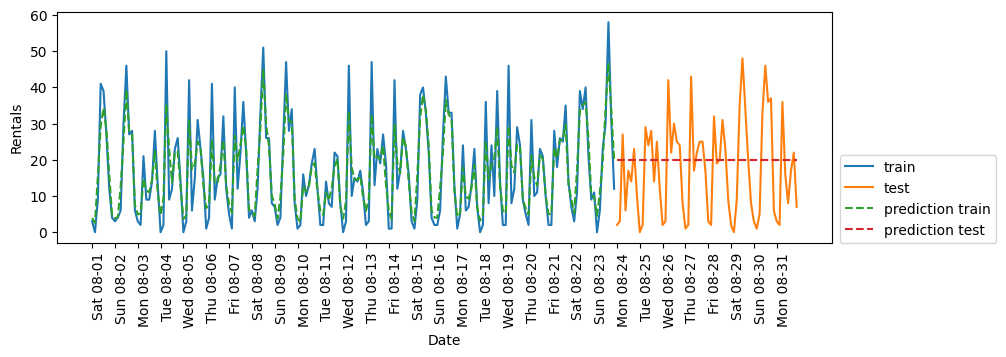

In [53]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
plt.figure()
eval_on_features(X, y, regressor)

The predictions on the training set are quite good, as is usual for random forests. However, for the test set, a constant line is predicted. The $R^2$ is $-0.04$, which means that we learned nothing. A negative $R^2$ means the model performs *worse* than simply predicting the mean:

$$R^2 < 0 \implies \sum (y_i - \hat{y}_i)^2 > \sum (y_i - \bar{y})^2$$

What happened? The problem lies in the combination of our feature and the random forest. The value of the POSIX time feature for the test set is outside of the range of the feature values in the training set: the points in the test set have timestamps that are later than all the points in the training set. Trees, and therefore random forests, **cannot extrapolate** to feature ranges outside the training set. For any new $x > x_{\max}^{\text{train}}$, the tree prediction is simply the average $y$ of the nearest leaf, which is the last training point.

Clearly we can do better than this. This is where our "expert knowledge" comes in. From looking at the rental figures in the training data, two factors seem to be very important: the time of day and the day of the week. So, let's add these two features. We can't really learn anything from the POSIX time, so we drop that feature. First, let's use only the hour of the day:

Test-set R^2: 0.60


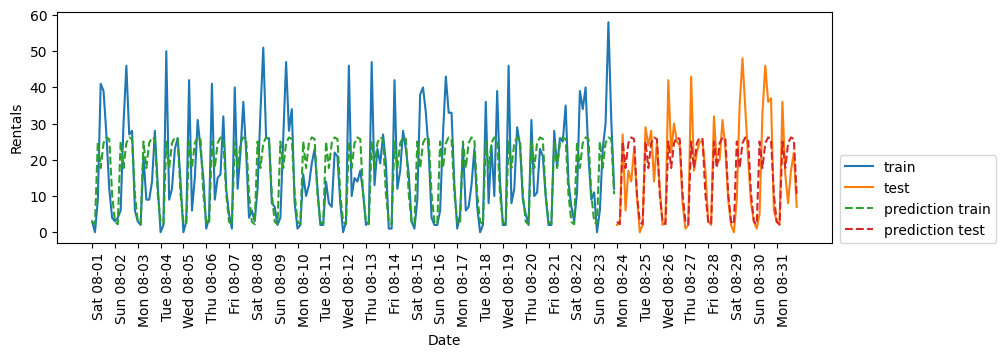

In [54]:
X_hour = citibike.index.hour.values.reshape(-1, 1)
eval_on_features(X_hour, y, regressor)

The R-squared is already much better at 0.60, and the predictions now show the same pattern for each day of the week -- high during the day, low at night. But the predictions clearly miss the weekly pattern: weekdays and weekends have different usage patterns. Now let's also add the day of the week:

Test-set R^2: 0.84


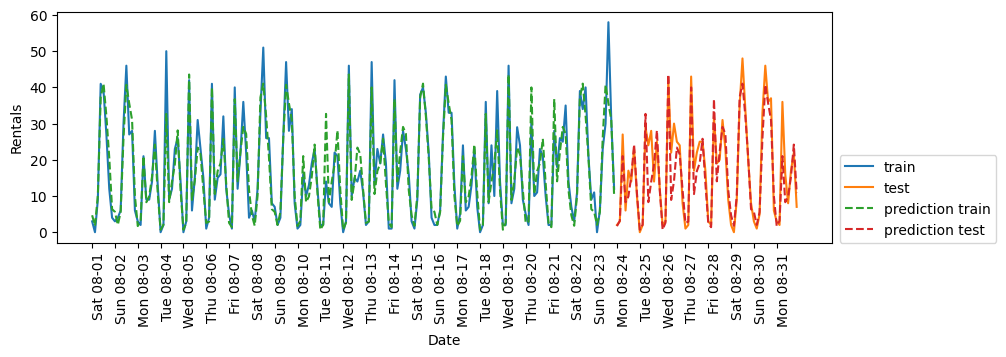

In [55]:
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1),
                          citibike.index.hour.values.reshape(-1, 1)])
eval_on_features(X_hour_week, y, regressor)

Now we have a model that captures the periodic behavior by considering the day of week and time of day. It has an $R^2$ of 0.84, and shows pretty good predictive performance. What this model likely is learning is the mean number of rentals for each combination of weekday and time of day from the first 23 days of August. This actually does not require a complex model like a random forest, so let's try with a simpler model, `LinearRegression`:

Test-set R^2: 0.13


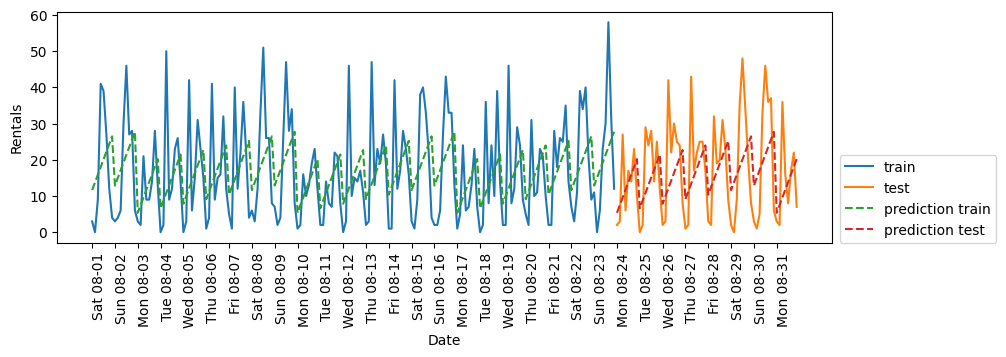

In [56]:
from sklearn.linear_model import LinearRegression
eval_on_features(X_hour_week, y, LinearRegression())

`LinearRegression` works much worse with an $R^2$ of only 0.13, and the periodic pattern looks odd. The reason for this is that we encoded day of week and time of day using integers, which are interpreted as continuous variables. Therefore, the linear model can only learn a linear function:

$$\hat{y} = w_1 \cdot \text{day\_of\_week} + w_2 \cdot \text{hour} + b$$

This means it learns that later in the day means more rentals (a single slope), but it cannot capture the rise-peak-fall pattern of actual usage. We can capture this by interpreting the integers as categorical variables, by transforming them using `OneHotEncoder`:

In [57]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

Test-set R^2: 0.62


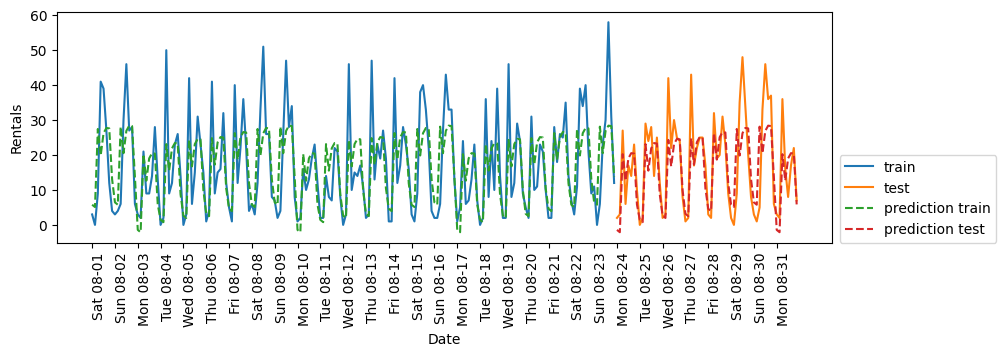

In [58]:
from sklearn.linear_model import Ridge
eval_on_features(X_hour_week_onehot, y, Ridge())

This gives us a much better match than the continuous feature encoding, with $R^2$ jumping from 0.13 to 0.62. Now the linear model learns one coefficient for each day of the week and one coefficient for each time of the day. With 7 days and 8 time slots, the model computes:

$$\hat{y} = \sum_{d=1}^{7} w_d^{\text{day}} \cdot z_d^{\text{day}} + \sum_{h=1}^{8} w_h^{\text{hour}} \cdot z_h^{\text{hour}} + b$$

That means that the "time of day" pattern is shared over all days of the week -- the model assumes Monday at 9 AM and Saturday at 9 AM differ only by a constant offset.

Using interaction features, we can allow the model to learn one coefficient for each combination of day and time of day:

Test-set R^2: 0.85


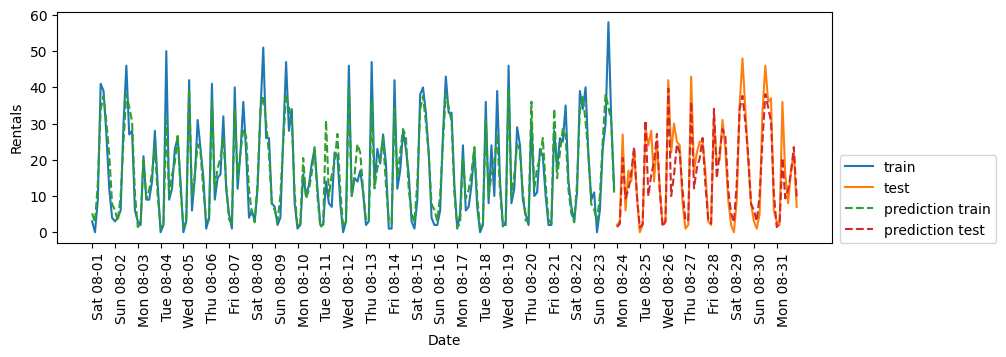

In [59]:
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True,
                                      include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)

This transformation finally yields a model that performs similarly well to the random forest, with an $R^2$ of 0.85. The interaction model computes:

$$\hat{y} = \sum_{d=1}^{7} \sum_{h=1}^{8} w_{d,h} \cdot z_d^{\text{day}} \cdot z_h^{\text{hour}} + \text{main effects} + b$$

This means the model learns a separate coefficient $w_{d,h}$ for every combination of day and hour -- for example, "Monday at 9 AM" gets a different coefficient than "Saturday at 9 AM." With $7 \times 8 = 56$ interaction terms plus 15 main effects, the model has $56 + 15 = 71$ non-zero features. A big benefit of this model is that it is very clear what is learned: one coefficient for each day and time. We can simply plot the coefficients learned by the model, something that would not be possible for the random forest.

First, we create feature names for the hour and day features:

In [60]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
features = day + hour

Then we name all the interaction features extracted by `PolynomialFeatures`, and keep only the features with nonzero coefficients:

In [61]:
features_poly = poly_transformer.get_feature_names_out(features)
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

Now we can visualize the coefficients learned by the linear model:

Text(0, 0.5, 'Feature')

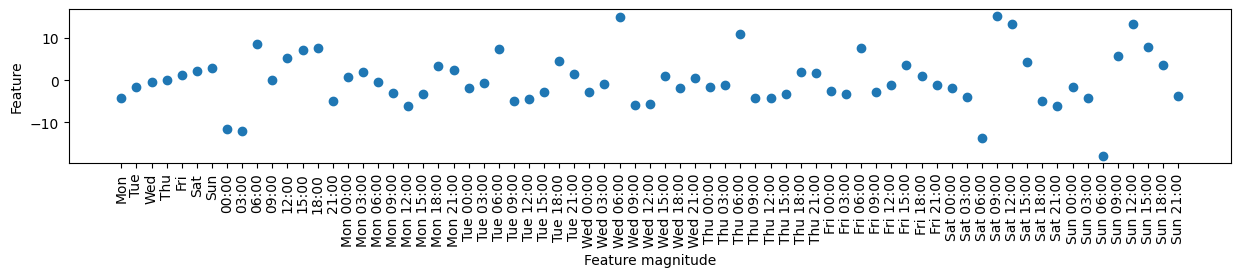

In [62]:
plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel("Feature magnitude")
plt.ylabel("Feature")

## Summary and Outlook

In this chapter, we discussed how to deal with different data types (in particular, with categorical variables). We emphasized the importance of representing data in a way that is suitable for the machine learning algorithm -- for example, by one-hot-encoding categorical variables. We also discussed the importance of engineering new features, and the possibility of utilizing expert knowledge in creating derived features from your data. The key mathematical themes were:

**One-hot encoding** transforms a categorical variable with $K$ values into $K$ binary features where $\sum_{k=1}^{K} z_k = 1$.

**Polynomial features** of degree $d$ expand $p$ features into $\binom{p+d}{d}$ features, capturing nonlinear relationships while keeping the model linear in parameters.

**Ridge regression** uses L2 regularization $\alpha\|\mathbf{w}\|_2^2$ to prevent overfitting in the expanded feature space, while **L1 regularization** $\alpha\|\mathbf{w}\|_1$ can perform automatic feature selection by driving coefficients to zero.

**Log transformation** $X_{\text{log}} = \log(X + 1)$ can convert skewed count data into approximately Gaussian features, dramatically improving linear model performance.

In particular, linear models might benefit greatly from generating new features via binning and adding polynomials and interactions, while more complex, nonlinear models like random forests and SVMs might be able to learn more complex tasks without explicitly expanding the feature space. In practice, the features that are used (and the match between features and method) is often the most important piece in making a machine learning approach work well.

Now that you have a good idea of how to represent your data in an appropriate way and which algorithm to use for which task, the next chapter will focus on evaluating the performance of machine learning models and selecting the right parameter settings.